**INITIALIZE PACKAGES AND DRIVE**

In [ ]:
import os
import shutil
import tensorflow as tf
import kagglehub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from google.colab import drive
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


drive.mount('/content/drive')
new_base_drive_dir = "/content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/"

# Define new base directory for the split dataset on Google Drive

drive_train_dir = os.path.join(new_base_drive_dir, "train")
drive_validation_dir = os.path.join(new_base_drive_dir, "validation")

Mounted at /content/drive


**DOWNLOAD DATA TO DRIVE FOR MODEL LEARNING**

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split
import kagglehub

# Remove existing directories to ensure a clean slate
if os.path.exists(drive_train_dir):
    shutil.rmtree(drive_train_dir)
    print(f"Removed existing directory: {drive_train_dir}")
if os.path.exists(drive_validation_dir):
    shutil.rmtree(drive_validation_dir)
    print(f"Removed existing directory: {drive_validation_dir}")

# Create the new train and validation directories
os.makedirs(drive_train_dir, exist_ok=True)
os.makedirs(drive_validation_dir, exist_ok=True)
print(f"Created new directory: {drive_train_dir}")
print(f"Created new directory: {drive_validation_dir}")

# Download the dataset from Kaggle
path = kagglehub.dataset_download("sanikamal/rock-paper-scissors-dataset")
print(f"Path to downloaded Kaggle dataset files: {path}")

# Construct the full paths to the original Kaggle train and validation image directories
original_kaggle_base_dir = os.path.join(path, "rock-paper-scissors/Rock-Paper-Scissors")
original_kaggle_train_dir = os.path.join(original_kaggle_base_dir, "train")
original_kaggle_validation_dir = os.path.join(original_kaggle_base_dir, "validation")

# Initialize lists to consolidate all image paths and their labels
all_image_paths = []
all_image_labels = []
classes = ['rock', 'paper', 'scissors']

# Iterate through the original train and validation directories to collect all image paths and labels
for base_dir in [original_kaggle_train_dir, original_kaggle_validation_dir]:
    for class_name in classes:
        class_path = os.path.join(base_dir, class_name)
        if os.path.exists(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if os.path.isfile(img_path):
                    all_image_paths.append(img_path)
                    all_image_labels.append(class_name)

print(f"Total images consolidated: {len(all_image_paths)}")

# Split the consolidated data into training and validation sets (80-20 ratio, stratified)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_image_paths, all_image_labels, test_size=0.2, stratify=all_image_labels, random_state=42
)

print(f"Training images after split: {len(train_paths)}")
print(f"Validation images after split: {len(val_paths)}")

# Helper function to copy files to their respective class directories
def copy_split_files(src_file_paths, labels, dest_base_dir):
    for src_path, label in zip(src_file_paths, labels):
        dest_class_dir = os.path.join(dest_base_dir, label)
        os.makedirs(dest_class_dir, exist_ok=True)
        shutil.copy(src_path, dest_class_dir)

# Copy training images to the new drive_train_dir
copy_split_files(train_paths, train_labels, drive_train_dir)
print(f"Copied {len(train_paths)} training images to {drive_train_dir}")

# Copy validation images to the new drive_validation_dir
copy_split_files(val_paths, val_labels, drive_validation_dir)
print(f"Copied {len(val_paths)} validation images to {drive_validation_dir}")

print("Dataset consolidation, splitting, and copying to Google Drive complete.")






Removed existing directory: /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/train
Removed existing directory: /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/validation
Created new directory: /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/train
Created new directory: /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/validation


100%|██████████| 452M/452M [00:12<00:00, 38.8MB/s]


Extracting files...
Path to downloaded Kaggle dataset files: /root/.cache/kagglehub/datasets/sanikamal/rock-paper-scissors-dataset/versions/1
Total images consolidated: 2520
Training images after split: 2016
Validation images after split: 504
Copied 2016 training images to /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/train
Copied 504 validation images to /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/validation
Dataset consolidation, splitting, and copying to Google Drive complete.


In [ ]:
#YT: splitting the training images once again and create the test dir:

# Define the new test directory
drive_test_dir = os.path.join(new_base_drive_dir, "test")
drive_final_train_dir = os.path.join(new_base_drive_dir, "final_train")

# Collect all image paths and labels from the current drive_train_dir (the 2016 images)
# We must do this BEFORE clearing drive_train_dir
current_train_image_paths = []
current_train_image_labels = []

for class_name in classes:
    class_path = os.path.join(drive_train_dir, class_name)
    if os.path.exists(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if os.path.isfile(img_path):
                current_train_image_paths.append(img_path)
                current_train_image_labels.append(class_name)

print(f"Total images from original training set to re-split: {len(current_train_image_paths)}")

# Clear drive_train_dir before re-populating it with the new split
if os.path.exists(drive_final_train_dir):
    shutil.rmtree(drive_final_train_dir)
    print(f"Removed existing directory: {drive_train_dir} (before re-populating)")
os.makedirs(drive_final_train_dir, exist_ok=True) # Recreate it
print(f"Re-created directory for new training split: {drive_final_train_dir}")

# Clean up previous drive_test_dir if it exists (in case of re-execution)
if os.path.exists(drive_test_dir):
    shutil.rmtree(drive_test_dir)
    print(f"Removed existing directory: {drive_test_dir}")
os.makedirs(drive_test_dir, exist_ok=True)
print(f"Created new directory for test split: {drive_test_dir}")


# Perform the 80-20 train-test split from the collected current training images
new_train_paths, new_test_paths, new_train_labels, new_test_labels = train_test_split(
    current_train_image_paths, current_train_image_labels, test_size=0.2, stratify=current_train_image_labels, random_state=42
)


# Copy images to new training and testing directories
copy_split_files(new_train_paths, new_train_labels, drive_final_train_dir)
print(f"Copied {len(new_train_paths)} images to new training directory: {drive_final_train_dir}")

copy_split_files(new_test_paths, new_test_labels, drive_test_dir)
print(f"Copied {len(new_test_paths)} images to new test directory: {drive_test_dir}")

print("Re-splitting of training data complete.")

Total images from original training set to re-split: 2016
Re-created directory for new training split: /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/final_train
Created new directory for test split: /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/test
Copied 1612 images to new training directory: /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/final_train
Copied 404 images to new test directory: /content/drive/MyDrive/RPS_2.0/rps_dataset_kaggle/test
Re-splitting of training data complete.


**DATA PRE PROCESSING**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# פרמטרים
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 3

# Set up the ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
    # Removed validation_split as we are using separate directories for train and validation
)

# Set up a separate ImageDataGenerator for validation (only rescaling, no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    drive_final_train_dir,
    #drive_train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Create the validation generator using the dedicated val_datagen
val_generator = val_datagen.flow_from_directory(
    drive_validation_dir,  # Use the separate validation directory
    target_size=IMG_SIZE,  # Consistent with IMG_SIZE
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Ensure order is maintained for evaluation
)

# Create a new test_generator pointing to the newly created drive_test_dir
# It's good practice to use a generator without augmentations for testing, similar to validation.
test_generator = val_datagen.flow_from_directory(
    drive_test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Ensure order is maintained for evaluation
)

# Print the class indices to verify the mapping
print("Validation class indices:", val_generator.class_indices)
print("Test class indices:", test_generator.class_indices)

# Check the classes and the indices
print("Class indices:", train_generator.class_indices)


Found 1612 images belonging to 3 classes.
Found 504 images belonging to 3 classes.
Found 404 images belonging to 3 classes.
Validation class indices: {'paper': 0, 'rock': 1, 'scissors': 2}
Test class indices: {'paper': 0, 'rock': 1, 'scissors': 2}
Class indices: {'paper': 0, 'rock': 1, 'scissors': 2}


**MODEL TRAINING**

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import AdamW
from sklearn.utils import class_weight
import numpy as np

# Load the VGG16 model with pre-trained weights, without the top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model layers (optional)
base_model.trainable = False

inputs = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(3, activation='softmax')(x)

model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=AdamW(), loss='categorical_crossentropy', metrics=['accuracy'])

# train_generator
class_labels = train_generator.classes
# Compute Weight Class
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)

# class_weight
class_weight_dict = dict(zip(np.unique(class_labels), class_weights))
print(class_weight_dict)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/RPS_2.0/vgg16_rps_best.keras', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

{np.int32(0): np.float64(0.9987608426270136), np.int32(1): np.float64(1.000620732464308), np.int32(2): np.float64(1.000620732464308)}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5397 - loss: 0.9639 - val_accuracy: 0.8651 - val_loss: 0.4712
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 727ms/step - accuracy: 0.8704 - loss: 0.4923 - val_accuracy: 0.9940 - val_loss: 0.1985
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 728ms/step - accuracy: 0.9092 - loss: 0.3116 - val_accuracy: 0.9901 - val_loss: 0.1145
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 693ms/step - accuracy: 0.9247 - loss: 0.2460 - val_accuracy: 0.9861 - val_loss: 0.0950
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 721ms/step - accuracy: 0.9509 - loss: 0.1732 - val_accuracy: 0.9960 - val_loss: 0.0574
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 37s 719ms/step - accuracy: 0.9493 - loss: 0.1689 - val_accuracy: 0.9980 - val_loss: 0.0512
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 737ms/step - accuracy: 0.9576 - loss: 0.1323 - val_accuracy: 0.9940 - val_loss: 0.0388
Epoch 8/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 36s 697ms/step - accuracy: 0.9590 - loss: 0.1336 - val_accurac

**IMAGE PREDICTION**

In [ ]:
import tempfile
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 1. Create a temporary directory
temp_dir = tempfile.mkdtemp()
print(f"Temporary directory created at: {temp_dir}")

# 2. Define the preprocess_image function
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create a batch dimension
    return img_array / 255.0  # Rescale pixel values

# 3. Define the predict_image function
def predict_image(model, preprocessed_img, class_names):
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    confidence = np.max(predictions, axis=1)[0] * 100
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name, confidence

# 4. Load the trained model
model_path = '/content/drive/MyDrive/RPS_2.0/vgg16_rps_best.keras'
loaded_model = load_model(model_path)
loaded_model.summary()
print(f"Model loaded successfully from: {model_path}")

Temporary directory created at: /tmp/tmp95a5jbod


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,507,275 (59.16 MB)

 Trainable params: 264,195 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 528,392 (2.02 MB)

Model loaded successfully from: /content/drive/MyDrive/RPS_2.0/vgg16_rps_best.keras


Generating predictions for the test set...
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step

Test Accuracy: 99.75%


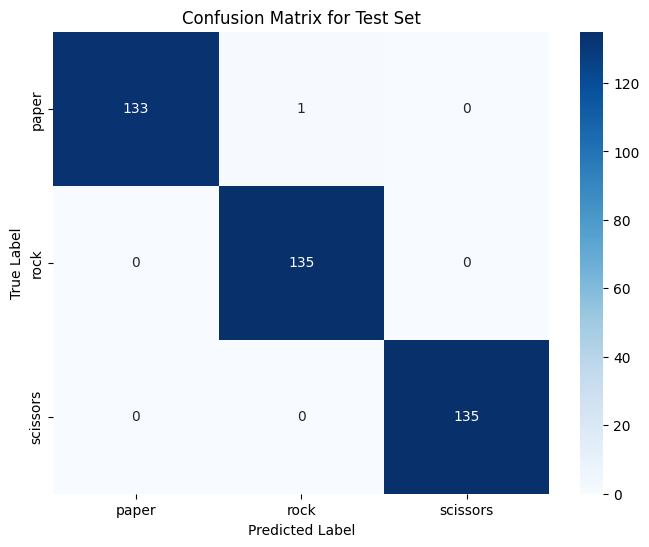

In [ ]:
# 1. Get predictions from the model on the test set
print("Generating predictions for the test set...")
test_predictions = loaded_model.predict(test_generator)
predicted_classes = np.argmax(test_predictions, axis=1)

# 2. Get true labels from the test generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 3. Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# 4. Generate Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# 5. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()


Generating predictions for the test set...
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 295ms/step

Test Accuracy: 100.00%


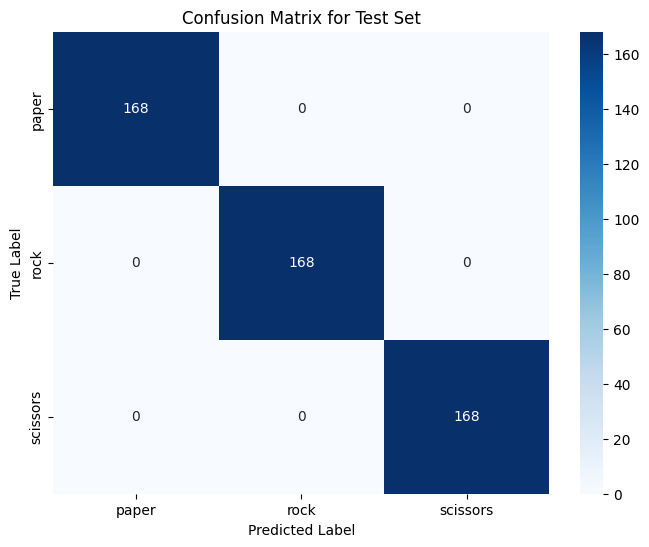

In [ ]:
# 1. Get predictions from the model on the validation set
print("Generating predictions for the test set...")
val_predictions = loaded_model.predict(val_generator)
predicted_classes = np.argmax(val_predictions, axis=1)

# 2. Get true labels from the test generator
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# 3. Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)
print(f"\nVal Accuracy: {accuracy * 100:.2f}%")

# 4. Generate Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# 5. Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')
plt.show()


The above output shows:

*   **Test Accuracy:** The overall accuracy of the model on the unseen test images.
*   **Confusion Matrix:** A visual representation of how well the model classified each category. Each row represents the actual class, and each column represents the predicted class. The diagonal elements indicate correctly classified instances, while off-diagonal elements show misclassifications.

In [ ]:
from google.colab import files
import zipfile
import io
import os

# Define the path for the new upload directory
upload_dir = drive_test_dir#'/content/drive/MyDrive/RPS_2.0/rps_test_photos'

# Create the directory if it doesn't exist
os.makedirs(upload_dir, exist_ok=True)
print(f"Upload directory ensured: {upload_dir}")

# Clear previous uploads to avoid conflicts
if os.path.exists(upload_dir) and len(os.listdir(upload_dir)) > 0:
    print(f"Clearing existing content in {upload_dir}...")
    for item in os.listdir(upload_dir):
        item_path = os.path.join(upload_dir, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)
    print("Previous content cleared.")

print("Please upload your image files or a zip archive.")
uploaded_files = files.upload()

for filename, content in uploaded_files.items():
    print(f'Processing file: {filename}')
    if filename.endswith('.zip'):
        # If it's a zip file, extract its contents
        with zipfile.ZipFile(io.BytesIO(content), 'r') as zip_ref:
            zip_ref.extractall(upload_dir)
        print(f"Extracted {filename} to {upload_dir}/")
    elif filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # If it's an image file, save it directly
        with open(os.path.join(upload_dir, filename), 'wb') as f:
            f.write(content)
        print(f"Saved image {filename} to {upload_dir}/")
    else:
        print(f"Skipping unsupported file type: {filename}")

print(f"All uploaded files processed and saved to {upload_dir}/")

Clearing existing content in /content/drive/MyDrive/RPS_2.0/rps_test_photos...
Previous content cleared.
Please upload your image files or a zip archive.


Saving frame_505.jpg to frame_505.jpg
Saving frame_580.jpg to frame_580.jpg
Saving frame_540.jpg to frame_540.jpg
Saving frame_0.jpg to frame_0.jpg
Processing file: frame_505.jpg
Saved image frame_505.jpg to /content/drive/MyDrive/RPS_2.0/rps_test_photos/
Processing file: frame_580.jpg
Saved image frame_580.jpg to /content/drive/MyDrive/RPS_2.0/rps_test_photos/
Processing file: frame_540.jpg
Saved image frame_540.jpg to /content/drive/MyDrive/RPS_2.0/rps_test_photos/
Processing file: frame_0.jpg
Saved image frame_0.jpg to /content/drive/MyDrive/RPS_2.0/rps_test_photos/
All uploaded files processed and saved to /content/drive/MyDrive/RPS_2.0/rps_test_photos/


In [ ]:
print(f"Total number of test images: {test_generator.n}")

Total number of test images: 404


In [ ]:
# Define the directory containing the images to predict
prediction_dir = upload_dir # This variable is already defined and points to '/content/drive/MyDrive/RPS_2.0/rps_test_photos'

# Get class names from the training generator (assuming its order is consistent)
class_names = list(train_generator.class_indices.keys())

print(f"Starting predictions for images in: {prediction_dir}")

# Iterate through each file in the prediction directory
for img_file in os.listdir(prediction_dir):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(prediction_dir, img_file)
        try:
            # Preprocess the image
            preprocessed_img = preprocess_image(img_path)

            # Make a prediction
            predicted_class, confidence = predict_image(loaded_model, preprocessed_img, class_names)

            print(f"File: {img_file}, Predicted: {predicted_class}, Confidence: {confidence:.2f}%")
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    else:
        print(f"Skipping non-image file: {img_file}")

print("Prediction process complete.")

Starting predictions for images in: /content/drive/MyDrive/RPS_2.0/rps_test_photos
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
File: frame_505.jpg, Predicted: scissors, Confidence: 97.79%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
File: frame_580.jpg, Predicted: paper, Confidence: 95.96%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
File: frame_540.jpg, Predicted: paper, Confidence: 99.84%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
File: frame_0.jpg, Predicted: paper, Confidence: 100.00%
Prediction process complete.
